# Sentiment Analysis

_Artificial Intelligence Nanodegree Program | Natural Language Processing_

---

With the rise of online social media platforms like Twitter, Facebook and Reddit, and the proliferation of customer reviews on sites like Amazon and Yelp, we now have access, more than ever before, to massive text-based data sets! They can be analyzed in order to determine how large portions of the population feel about certain products, events, etc. This sort of analysis is called _sentiment analysis_. In this notebook we build an end-to-end sentiment classification system from scratch.



## Step 1: Exploring the data!

The dataset we are going to use is very popular among researchers in Natural Language Processing, usually referred to as the [IMDb dataset](http://ai.stanford.edu/~amaas/data/sentiment/). It consists of movie reviews from the website [imdb.com](http://www.imdb.com/), each labeled as either '**pos**itive', if the reviewer enjoyed the film, or '**neg**ative' otherwise.

> Maas, Andrew L., et al. [Learning Word Vectors for Sentiment Analysis](http://ai.stanford.edu/~amaas/data/sentiment/). In _Proceedings of the 49th Annual Meeting of the Association for Computational Linguistics: Human Language Technologies_. Association for Computational Linguistics, 2011.



In [1]:
import os
import glob

def read_imdb_data(data_dir='data/imdb-reviews'):
    """Read IMDb movie reviews from given directory.
    
    Directory structure expected:
    - data/
        - train/
            - pos/
            - neg/
        - test/
            - pos/
            - neg/
    
    """

    # Data, labels to be returned in nested dicts matching the dir. structure
    data = {}
    labels = {}

    # Assume 2 sub-directories: train, test
    for data_type in ['train', 'test']:
        data[data_type] = {}
        labels[data_type] = {}

        # Assume 2 sub-directories for sentiment (label): pos, neg
        for sentiment in ['pos', 'neg']:
            data[data_type][sentiment] = []
            labels[data_type][sentiment] = []
            
            # Fetch list of files for this sentiment
            path = os.path.join(data_dir, data_type, sentiment, '*.txt')
            files = glob.glob(path)
            
            # Read reviews data and assign labels
            for f in files:
                with open(f) as review:
                    data[data_type][sentiment].append(review.read())
                    labels[data_type][sentiment].append(sentiment)
            
            assert len(data[data_type][sentiment]) == len(labels[data_type][sentiment]), \
                    "{}/{} data size does not match labels size".format(data_type, sentiment)
    
    # Return data, labels as nested dicts
    return data, labels


data, labels = read_imdb_data()
print("IMDb reviews: train = {} pos / {} neg, test = {} pos / {} neg".format(
        len(data['train']['pos']), len(data['train']['neg']),
        len(data['test']['pos']), len(data['test']['neg'])))

IMDb reviews: train = 12500 pos / 12500 neg, test = 12500 pos / 12500 neg


Now that the data is loaded in, let's take a quick look at one of the positive reviews:

In [2]:
print(data['train']['pos'][2])
print(labels['train']['pos'][5])

This movie was beautiful. It was full of memorable imagery, good acting, and touching subject matter. It would be very easy to write it off as being too sentimental, but that is the sentiments this type of a movie is trying to achieve. I was totally involved in the story's unfolding and presentation. There were a few cheesy shots, but such is to be expected in a religious propaganda film. The only complaint I can conjure is there wasn't a ton of details. However, this movie wasn't created to explain every element of Joseph Smith's life, ministry, triumphs, controversies, failures etc.; it was designed for a quick glimpse at a few highlights of one of the most amazing American and historical religious figures of all time.
pos


And one with a negative sentiment:

In [3]:
print(data['train']['neg'][2])

It's a good thing The Score came along for Marlon Brando as a farewell performance because I'd hate to think of him going out on Free Money. Not what his fans ought to remember him by.<br /><br />Brando in his last years is looking more like Orson Welles and Free Money is the kind of film Welles would have done looking for financing of his own work. Brando is the warden of a local prison which in America, when it's located in a small rural setting is usually the largest employer in the area. That gives one who is in charge a lot of clout. <br /><br />Unfortunately he has one weakness he indulges, his two twin bimbos otherwise known as daughters. Even when they get simultaneously pregnant by a pair of losers, Charlie Sheen and Thomas Haden Church, their hearts still belong to Daddy.<br /><br />Not to fear because Brando's willing to give them jobs in the prison where they work under conditions not much better than the convicts have. What to do, but commit a robbery of a train which goes

We can also make a wordcloud visualization of the reviews.

In [4]:
# Installing wordcloud
!pip install wordcloud

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


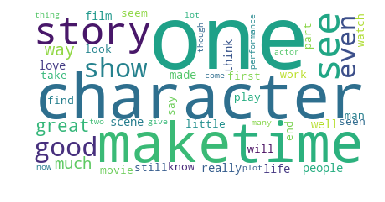

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS

sentiment = 'pos'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

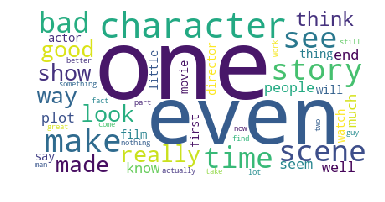

In [6]:
sentiment = 'neg'

# Combine all reviews for the desired sentiment
combined_text = " ".join([review for review in data['train'][sentiment]])

# Initialize wordcloud object
wc = WordCloud(background_color='white', max_words=50,
        # update stopwords to include common words like film and movie
        stopwords = STOPWORDS.update(['br','film','movie']))

# Generate and plot wordcloud
plt.imshow(wc.generate(combined_text))
plt.axis('off')
plt.show()

Try changing the sentiment to `'neg'` and see if you can spot any obvious differences between the wordclouds.

### Form training and test sets

Combine the positive and negative documents to get one unified training set and one unified test set.

In [31]:
from sklearn.utils import shuffle

def prepare_imdb_data(data):
    """Prepare training and test sets from IMDb movie reviews."""
    
    # TODO: Combine positive and negative reviews and labels
    data_train = data['train']['pos'] + data['train']['neg']
    labels_train = labels['train']['pos'] + labels['train']['neg']
    data_test = data['test']['pos'] + data['test']['neg']
    labels_test = labels['test']['pos'] + labels['test']['neg']
    
    
    # TODO: Shuffle reviews and corresponding labels within training and test sets
    
    data_train, labels_train = shuffle(data_train, labels_train)
    data_test, labels_test = shuffle(data_test, labels_test)
    
    
    # Return a unified training data, test data, training labels, test labets
    return data_train, data_test, labels_train, labels_test


data_train, data_test, labels_train, labels_test = prepare_imdb_data(data)
print("IMDb reviews (combined): train = {}, test = {}".format(len(data_train), len(data_test)))

IMDb reviews (combined): train = 25000, test = 25000


## Step 2. Preprocessing

As you might have noticed in the sample reviews, our raw data includes HTML. Therefore there are HTML tags that need to be removed. We also need to remove non-letter characters, normalize uppercase letters by converting them to lowercase, tokenize, remove stop words, and stem the remaining words in each document.

### TODO: Convert each review to words

As your next task, you should complete the function `review_to_words()` that performs all these steps. For your convenience, in the Python cell below we provide you with all the libraries that you may need in order to accomplish these preprocessing steps. Make sure you can import all of them! (If not, pip install from a terminal and run/import again.)

In [32]:
# BeautifulSoup to easily remove HTML tags
from bs4 import BeautifulSoup 

# RegEx for removing non-letter characters
import re

# NLTK library for the remaining steps
import nltk
nltk.download("stopwords")   # download list of stopwords (only once; need not run it again)
from nltk.corpus import stopwords # import stopwords

from nltk.stem.porter import *
stemmer = PorterStemmer()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
def review_to_words(review):
    """Convert a raw review string into a sequence of words."""
    
    # Remove HTML tags and non-letters,
    # convert to lowercase, tokenize,
    # remove stopwords and stem
    
    soup = BeautifulSoup(review, "html5lib")
    
    text = soup.get_text()

    
    text = re.sub(r"[^a-zA-Z0-9]", " ", text.lower())
    
    #from string import punctuation
    words = text.split()

    stop = set(stopwords.words('english'))
    words = [w for w in words if w not in stop]
    
    words = [stemmer.stem(w) for w in words]
    
#    review = ''.join(c for c in review if c not in punctuation)
    
 #   text = stemmer.stem(review)
    
   # tokens = nltk.word_tokenize(text)

    return words


review_to_words("""This is just a <em>test</em>.<br/><br />
But if it wasn't a test, it would make for a <b>Great</b> movie review!""")

['test', 'test', 'would', 'make', 'great', 'movi', 'review']

With the function `review_to_words()` fully implemeneted, we can apply it to all reviews in both training and test datasets. This can take a while, so we build in a mechanism to write to a cache file and retrieve from it later.

In [34]:
import pickle

cache_dir = os.path.join("cache", "sentiment_analysis")  # where to store cache files
os.makedirs(cache_dir, exist_ok=True)  # ensure cache directory exists

def preprocess_data(data_train, data_test, labels_train, labels_test,
                    cache_dir=cache_dir, cache_file="preprocessed_data.pkl"):
    """Convert each review to words; read from cache if available."""

    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = pickle.load(f)
            print("Read preprocessed data from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Preprocess training and test data to obtain words for each review
        words_train = list(map(review_to_words, data_train))
        words_test = list(map(review_to_words, data_test))
        
        # Write to cache file for future runs
        if cache_file is not None:
            cache_data = dict(words_train=words_train, words_test=words_test,
                              labels_train=labels_train, labels_test=labels_test)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                pickle.dump(cache_data, f)
            print("Wrote preprocessed data to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        words_train, words_test, labels_train, labels_test = (cache_data['words_train'],
                cache_data['words_test'], cache_data['labels_train'], cache_data['labels_test'])
    
    return words_train, words_test, labels_train, labels_test


# Preprocess data
words_train, words_test, labels_train, labels_test = preprocess_data(
        data_train, data_test, labels_train, labels_test)

# Take a look at a sample
print("\n--- Raw review ---")
print(data_train[1])
print("\n--- Preprocessed words ---")
print(words_train[1])
print("\n--- Label ---")
print(labels_train[1])

Read preprocessed data from cache file: preprocessed_data.pkl

--- Raw review ---
I really can say I felt the movie in its right essence where the mind games from dreamy reality enter into the surreal aspect of future faced by Tom Cruise. I didn't cared much about Tom Cruise's acting prowess but I must say that he seems to impress at every point in the movie...not simply due to an engaging storyline but also due to his self being imparted to the lead character....they merge and then speak and its beautiful. However I must say this movie doesn't come under the "average flick of weekend" which you pick at random and watch gleefully; It carries strong sentiments and characters so don't wash this one down with your beer and pop-corns. It certainly needs more than that.

--- Preprocessed words ---
['blond', 'blonder', 'pamela', 'anderson', 'denis', 'richard', 'almost', 'everi', 'scene', 'want', 'movi', 'utterli', 'unreason', 'feel', 'like', 'late', 'era', 'carri', 'seri', 'longer', 'blaze',

## Step 3: Extracting Bag-of-Words features

Now that each document has been preprocessed, we can transform each into a Bag-of-Words feature representation. Note that we need to create this transformation based on the training data alone, as we are not allowed to peek at the testing data at all!

The dictionary or _vocabulary_ $V$ (set of words shared by documents in the training set) used here will be the one on which we train our supervised learning algorithm. Any future test data must be transformed in the same way for us to be able to apply the learned model for prediction. It is important to store the transformation / vocabulary as well.

> **Note**: The set of words in the training set may not be exactly the same as the test set. If we encounter a word during testing that we haven't seen before, we'll have to ignore it, or replace it with a special `<UNK>` token.

### Compute Bag-of-Words features

Implement the `extract_BoW_features()` function, apply it to both training and test datasets, and store the results in `features_train` and `features_test` NumPy arrays, respectively. Choose a reasonable vocabulary size, say $|V| = 5000$, and keep only the top $|V|$ occuring words and discard the rest. This number will also serve as the number of columns in the BoW matrices.



In [39]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.externals import joblib
# joblib is an enhanced version of pickle that is more efficient for storing NumPy arrays

def extract_BoW_features(words_train, words_test, vocabulary_size=5000,
                         cache_dir=cache_dir, cache_file="bow_features.pkl"):
    """Extract Bag-of-Words for a given set of documents, already preprocessed into words."""
    
    # If cache_file is not None, try to read from it first
    cache_data = None
    if cache_file is not None:
        try:
            with open(os.path.join(cache_dir, cache_file), "rb") as f:
                cache_data = joblib.load(f)
            print("Read features from cache file:", cache_file)
        except:
            pass  # unable to read from cache, but that's okay
    
    # If cache is missing, then do the heavy lifting
    if cache_data is None:
        # Fit a vectorizer to training documents and use it to transform them
        # NOTE: Training documents have already been preprocessed and tokenized into words;
        #       pass in dummy functions to skip those steps, e.g. preprocessor=lambda x: x
        vectorizer = CountVectorizer(max_features=vocabulary_size,
                preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
        features_train = vectorizer.fit_transform(words_train).toarray()
#        features_train = vectorizer.transform(words_train)

        # TODO: Apply the same vectorizer to transform the test documents (ignore unknown words)
#        vectorizer.fit(words_test)
        features_test = vectorizer.transform(words_test).toarray()
        
          
        # NOTE: Remember to convert the features using .toarray() for a compact representation
        
        # Write to cache file for future runs (store vocabulary as well)
        if cache_file is not None:
            vocabulary = vectorizer.vocabulary_
            cache_data = dict(features_train=features_train, features_test=features_test,
                             vocabulary=vocabulary)
            with open(os.path.join(cache_dir, cache_file), "wb") as f:
                joblib.dump(cache_data, f)
            print("Wrote features to cache file:", cache_file)
    else:
        # Unpack data loaded from cache file
        features_train, features_test, vocabulary = (cache_data['features_train'],
                cache_data['features_test'], cache_data['vocabulary'])
    
    # Return both the extracted features as well as the vocabulary
    return features_train, features_test, vocabulary


# Extract Bag of Words features for both training and test datasets
features_train, features_test, vocabulary = extract_BoW_features(words_train, words_test)

# Inspect the vocabulary that was computed
print("Vocabulary: {} words".format(len(vocabulary)))

import random
print("Sample words: {}".format(random.sample(list(vocabulary.keys()), 8)))

# Sample
print("\n--- Preprocessed words ---")
print(words_train[5])
print("\n--- Bag-of-Words features ---")
print(features_train[5])
print("\n--- Label ---")
print(labels_train[5])

Read features from cache file: bow_features.pkl
Vocabulary: 5000 words
Sample words: ['blue', 'dancer', 'advantag', 'unpredict', 'assassin', 'gillian', 'singer', 'incoher']

--- Preprocessed words ---
['kid', '50', '60', 'anyth', 'connect', 'disney', 'definit', 'great', 'happen', 'abl', 'get', 'actor', 'actress', 'want', 'best', 'time', 'somehow', 'disney', 'manag', 'screw', 'thing', 'spite', 'abund', 'resourc', 'disney', 'afford', 'best', 'writer', 'best', 'produc', 'director', 'still', 'screw', 'thing', 'movi', 'crap', 'sad', 'thing', 'suspect', 'disney', 'arrog', 'even', 'know', 'movi', 'good', 'bad', 'due', 'talent', 'actor', 'even', 'give', '3', '10']

--- Bag-of-Words features ---
[0 0 0 ... 0 0 0]

--- Label ---
neg


Visualize the Bag-of-Words feature vector for one of our training documents.

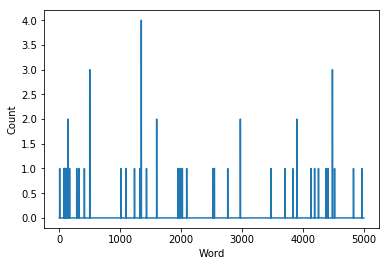

In [40]:
# Plot the BoW feature vector for a training document
plt.plot(features_train[5,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

#### Reflecting on Bag-of-Words feature representation

What is the average sparsity level of BoW vectors in our training set? In other words, on average what percentage of entries in a BoW feature vector are zero?


### Zipf's law

[Zipf's law](https://en.wikipedia.org/wiki/Zipf%27s_law), named after the famous American linguist George Zipf, is an empirical law stating that given a large collection of documents, the frequency of any word is inversely proportional to its rank in the frequency table. So the most frequent word will occur about twice as often as the second most frequent word, three times as often as the third most frequent word, and so on. In the figure below we plot number of appearances of each word in our training set against its rank.

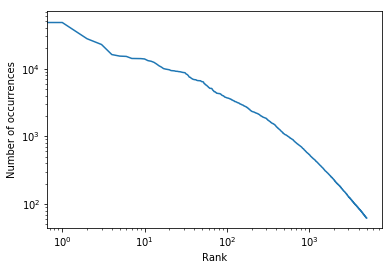

In [41]:
# Find number of occurrences for each word in the training set
word_freq = features_train.sum(axis=0)

# Sort it in descending order
sorted_word_freq = np.sort(word_freq)[::-1]

# Plot 
plt.plot(sorted_word_freq)
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.xlabel('Rank')
plt.ylabel('Number of occurrences')
plt.show()

#### Question: Zipf's law

What is the total number of occurrences of the most frequent word? What is the the total number of occurrences of the second most frequent word? Do our numbers follow  Zipf's law? If not, why?

#### Answer:

...

### TODO: Normalize feature vectors

Bag-of-Words features are intuitive to understand as they are simply word counts. But counts can vary a lot, and potentially throw off learning algorithms later in the pipeline. So, before we proceed further, let's normalize the BoW feature vectors to have unit length.

This makes sure that each document's representation retains the unique mixture of feature components, but prevents documents with large word counts from dominating those with fewer words.

In [46]:
import sklearn.preprocessing as pr

# TODO: Normalize BoW features in training and test set
features_train = pr.normalize(features_train, axis=1)
features_test = pr.normalize(features_test, axis=1)


## Step 4: Classification using BoW features

Now that the data has all been properly transformed, we can feed it into a classifier. To get a baseline model, we train a Naive Bayes classifier from scikit-learn (specifically, [`GaussianNB`](http://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)), and evaluate its accuracy on the test set.

In [47]:
from sklearn.naive_bayes import GaussianNB

# Train a Guassian Naive Bayes classifier
clf1 = GaussianNB()
clf1.fit(features_train, labels_train)

# Calculate the mean accuracy score on training and test sets
print("[{}] Accuracy: train = {}, test = {}".format(
        clf1.__class__.__name__,
        clf1.score(features_train, labels_train),
        clf1.score(features_test, labels_test)))

[GaussianNB] Accuracy: train = 0.8198, test = 0.72768


Tree-based algorithms often work quite well on Bag-of-Words as their highly discontinuous and sparse nature is nicely matched by the structure of trees. Next, we will try to improve on the Naive Bayes classifier's performance by using scikit-learn's Gradient-Boosted Decision Tree classifer.

### Gradient-Boosted Decision Tree classifier

Use [`GradientBoostingClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) from scikit-learn to classify the BoW data. This model has a number of parameters. We use default parameters for some of them and pre-set the rest for you, except one: `n_estimators`. 
> Use a model selection technique such as cross-validation, grid-search, or an information criterion method, to find an optimal value for the hyperparameter.

In [50]:
from sklearn.ensemble import GradientBoostingClassifier

n_estimators = 12

def classify_gboost(X_train, X_test, y_train, y_test):        
    # Initialize classifier
    clf = GradientBoostingClassifier(n_estimators=n_estimators, learning_rate=1.0, max_depth=1, random_state=0)

    # TODO: Classify the data using GradientBoostingClassifier
    clf.fit(X_train, y_train)
    
    # TODO(optional): Perform hyperparameter tuning / model selection
    
    # TODO: Print final training & test accuracy
    print("[{}] Accuracy: train = {}, test = {}".format(
            clf.__class__.__name__,
            clf.score(X_train, y_train),
            clf.score(X_test, y_test)))
        
    
    # Return best classifier model
    return clf


clf2 = classify_gboost(features_train, features_test, labels_train, labels_test)

[GradientBoostingClassifier] Accuracy: train = 0.7416, test = 0.74264


### Adverserial testing

Write a short movie review to trick our machine learning model! That is, a movie review with a clear positive or negative sentiment that our model will classify incorrectly.

>You might want to take advantage of the biggest weakness of the Bag-of-Words scheme!

In [52]:
# Write a sample review and set its true sentiment
my_review = "The movie is not as good as Star Wars, The Last Jedi."
true_sentiment = 'neg'  # sentiment must be 'pos' or 'neg'

# Apply the same preprocessing and vectorizing steps as we did for our training data
my_words = review_to_words(my_review)
vectorizer = CountVectorizer(vocabulary=vocabulary,
                             preprocessor=lambda x: x, tokenizer=lambda x: x)  # already preprocessed
my_bow_features = vectorizer.transform([my_words]).toarray()  # pass an array of 1 element

# Then call our classifier to label it
predicted_sentiment = clf2.predict(my_bow_features)[0]
print("--- My review ---")
print(my_review)
print("\n--- Preprocessed words ---")
print(my_words)
print("\nTrue sentiment: {}, predicted sentiment: {}".format(true_sentiment, predicted_sentiment))

# Then call our classifier to label it


--- My review ---
The movie is not as good as Star Wars, The Last Jedi.

--- Preprocessed words ---
['movi', 'good', 'star', 'war', 'last', 'jedi']

True sentiment: neg, predicted sentiment: pos


## Extensions

There are several ways in which we can build upon this notebook. Each comes with its set of challenges, but can be a rewarding experience.

- The first thing is to try and improve the accuracy of our model by experimenting with different architectures, layers and parameters. How good can we get without taking prohibitively long to train? How do we prevent overfitting?

- Then, we may want to deploy the model as a mobile app or web service. What do you need to do in order to package your model for such deployment? How would we accept a new review, convert it into a form suitable for our model, and perform the actual prediction? (Note that the same environment we used during training may not be available.)

- One simplification we made in this notebook is to limit the task to binary classification. The dataset actually includes a more fine-grained review rating that is indicated in each review's filename (which is of the form `<[id]_[rating].txt>` where `[id]` is a unique identifier and `[rating]` is on a scale of 1-10; note that neutral reviews > 4 or < 7 have been excluded). How would you modify the notebook to perform regression on the review ratings? In what situations is regression more useful than classification, and vice-versa?

